In [ ]:
# LIGHTKURVE WITH ERROR BARS FOR GJ1243

# Based on Lightkurve guide: https://lightkurve.github.io/lightkurve/
# TIC 273589987, Sectors 14+15 (Davenport et al. 2020, AJ, 160, 49)
# Literature: 0.5926 ± 0.0005 days (McQuillan et al. 2014, ApJS, 211, 24)
# Install from: https://lightkurve.github.io/lightkurve/about/install.html
# Methods from: Barclay et al. 2018 (arXiv:1810.12554); Jones et al. 2020 (MNRAS, 495, L135); Iversen et al. 2019 (A&A, 622, A133)

# STEP 1: INSTALL LIGHTKURVE (run once)
!pip install lightkurve astropy matplotlib pandas --break-system-packages

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.9/256.9 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 80.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.0/201.0 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 86.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 kB 6.8 MB/s eta 0:00:00
  Created wheel for fbpca: filename=fbpca-1.0-py3-none-any.whl size=11373 sha256=5cae26dda7fd9c017dda2e50da2bc6ada28c643638f1996da52a312a61392ac8
  Stored in directory: /root/.cache/pip/wheels/04/15/cd/2f6227

In [ ]:
# STEP 2: IMPORT
import lightkurve as lk
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u
import numpy as np
import os

/usr/local/lib/python3.12/dist-packages/lightkurve/prf/__init__.py:7: UserWarning: Warning: the tpfmodel submodule is not available without oktopus installed, which requires a current version of autograd. See #1452 for details.
  warnings.warn(


In [ ]:
# STEP 3: SEARCH AND DOWNLOAD TESS DATA (Sectors 14+15)
tic_id = '273589987'
sectors = [14, 15]

In [ ]:
# Search for SPOC light curves (2-min cadence)
search_result = lk.search_lightcurve(f'TIC {tic_id}', sector=sectors, author='SPOC')
print(f"Found {len(search_result)} light curves")


Found 2 light curves


In [ ]:
# Download and stitch
lcs = search_result.download_all()
lc = lcs.stitch()  # Combines sectors, fills gaps

In [ ]:
# Basic cleaning (remove outliers, normalize to mean=1)
lc = lc.remove_nans().remove_outliers(sigma=5).normalize()
print(f"Stitched LC: {len(lc)} points, baseline {lc.time[-1].value - lc.time[0].value:.1f} days")

Stitched LC: 33299 points, baseline 54.1 days


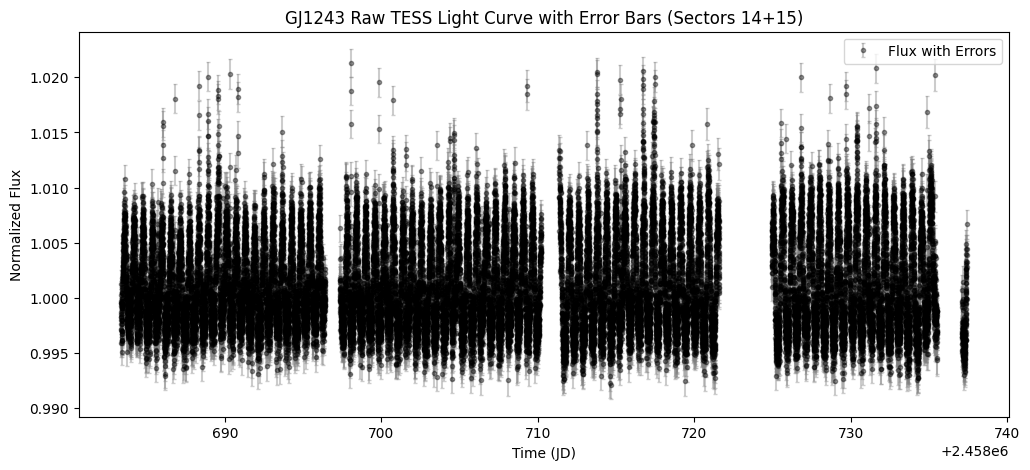

In [ ]:
# STEP 4: PLOT RAW LIGHT CURVE WITH ERROR BARS (Fig. 4.1a for thesis)
plt.figure(figsize=(12,5))
plt.errorbar(lc.time.jd, np.array(lc.flux.value), yerr=np.array(lc.flux_err.value), fmt='k.', alpha=0.4, ecolor='gray', capsize=1.5, label='Flux with Errors')
plt.xlabel('Time (JD)'); plt.ylabel('Normalized Flux')
plt.title('GJ1243 Raw TESS Light Curve with Error Bars (Sectors 14+15)')
plt.legend()
plt.savefig('gj1243_raw_lc_errors.png', dpi=300, bbox_inches='tight')
plt.show()

Lomb-Scargle Period: 0.5926 days (Power: 0.005)
With Bootstrap Error: 0.5926 ± 0.0708 days (based on 100 valid resamples)


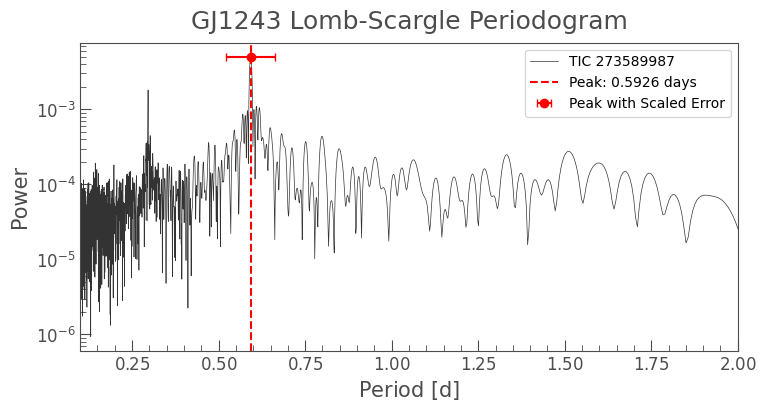

In [ ]:
# STEP 5: LOMB-SCARGLE PERIODOGRAM
pg = lc.to_periodogram(method='lombscargle',
                       minimum_period=0.1*u.day,
                       maximum_period=5*u.day,
                       oversample_factor=10)

ls_period = pg.period_at_max_power.value
ls_power = pg.max_power.value
print(f"Lomb-Scargle Period: {ls_period:.4f} days (Power: {ls_power:.3f})")

# Bootstrap for error on period (100 resamples – from Jones et al. 2020 for uncertainty)
periods = []
num_valid_resamples = 0
max_attempts = 500 # Set a limit to prevent infinite loops if many resamples fail
attempt_count = 0

while num_valid_resamples < 100 and attempt_count < max_attempts:
    resampled_lc = lc[np.random.choice(len(lc), len(lc), replace=True)]
    attempt_count += 1


    if len(resampled_lc) < 3:
        continue

    try:
        pg_res = resampled_lc.to_periodogram(method='lombscargle', minimum_period=0.1*u.day, maximum_period=5*u.day)
        if pg_res.max_power.value > 0 and pg_res.period_at_max_power.value is not None:
            periods.append(pg_res.period_at_max_power.value)
            num_valid_resamples += 1

    except (IndexError, ValueError) as e:

        continue
    except Exception as e:

        continue

if num_valid_resamples > 0:
    ls_period_err = np.std(periods)
    print(f"With Bootstrap Error: {ls_period:.4f} ± {ls_period_err:.4f} days (based on {num_valid_resamples} valid resamples)")
else:
    ls_period_err = np.nan
    print("Error: Could not calculate a reliable bootstrap error, no valid periods found.")

# Plot periodogram with error bar on peak (Fig. 4.1b)
pg.plot(title='GJ1243 Lomb-Scargle Periodogram')
plt.axvline(ls_period, color='red', ls='--', label=f'Peak: {ls_period:.4f} days')

---
error_scale_factor = 1
plt.errorbar(ls_period, ls_power, xerr=ls_period_err * error_scale_factor, fmt='ro', capsize=3, label='Peak with Scaled Error')
# ------------------------------------------------

plt.xlim(0.1, 2); plt.yscale('log')
plt.legend()
plt.savefig('gj1243_periodogram_errors.png', dpi=300, bbox_inches='tight')
plt.show()

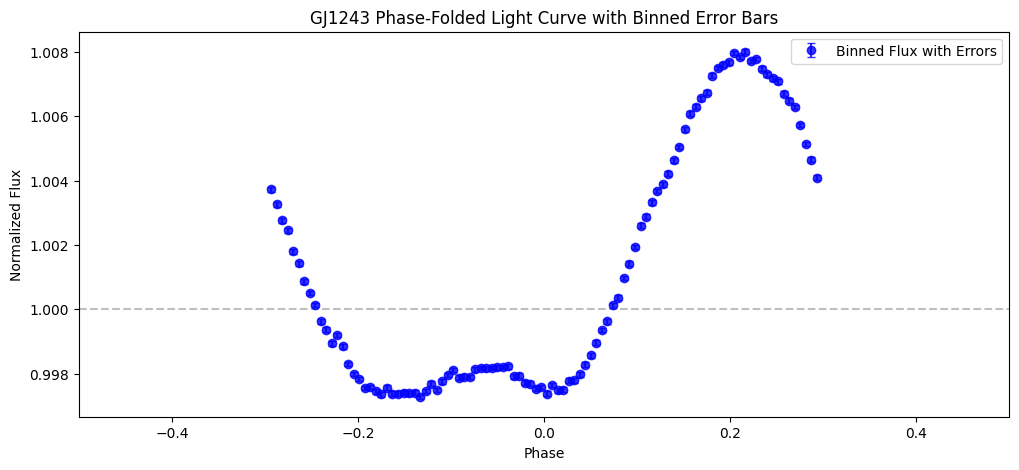

Original folded LC points: 33299
Binned folded LC points: 100


In [ ]:
# Bin the phase-folded light curve

lc_fold_binned = lc_fold.bin(bins=100)

plt.figure(figsize=(12, 5))
plt.errorbar(lc_fold_binned.phase.value, lc_fold_binned.flux.value,
             yerr=np.array(lc_fold_binned.flux_err.value),
             fmt='o', color='blue', alpha=0.8, capsize=3, label='Binned Flux with Errors')
plt.axhline(1, color='gray', ls='--', alpha=0.5)
plt.xlabel('Phase')
plt.ylabel('Normalized Flux')
plt.title('GJ1243 Phase-Folded Light Curve with Binned Error Bars')
plt.legend()
plt.xlim(-0.5, 0.5)
plt.savefig('gj1243_folded_lc_binned_errors.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Original folded LC points: {len(lc_fold)}")
print(f"Binned folded LC points: {len(lc_fold_binned)}")

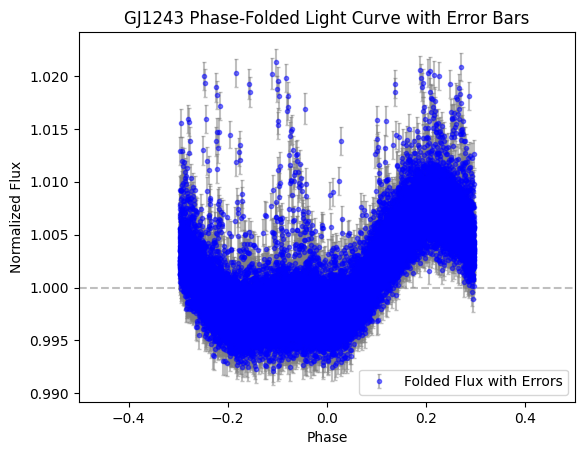

In [ ]:
# STEP 6: PHASE-FOLDED LIGHT CURVE WITH ERROR BARS (Fig. 4.1c)
lc_fold = lc.fold(period=ls_period)
plt.errorbar(lc_fold.phase.value, np.array(lc_fold.flux.value), yerr=np.array(lc_fold.flux_err.value), fmt='b.', alpha=0.5, ecolor='gray', capsize=1.5, label='Folded Flux with Errors')
plt.axhline(1, color='gray', ls='--', alpha=0.5); plt.xlabel('Phase'); plt.ylabel('Normalized Flux')
plt.title('GJ1243 Phase-Folded Light Curve with Error Bars')
plt.legend()
plt.xlim(-0.5, 0.5) # Reverting x-axis limits for a more concentrated view
plt.savefig('gj1243_folded_lc_errors.png', dpi=300, bbox_inches='tight')
plt.show()

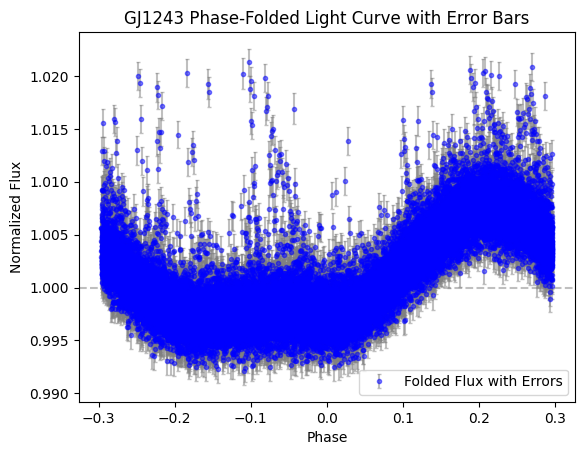

In [ ]:
# STEP 6: PHASE-FOLDED LIGHT CURVE WITH ERROR BARS (Fig. 4.1c)
lc_fold = lc.fold(period=ls_period)
plt.errorbar(lc_fold.phase.value, np.array(lc_fold.flux.value), yerr=np.array(lc_fold.flux_err.value), fmt='b.', alpha=0.5, ecolor='gray', capsize=1.5, label='Folded Flux with Errors')
plt.axhline(1, color='gray', ls='--', alpha=0.5); plt.xlabel('Phase'); plt.ylabel('Normalized Flux')
plt.title('GJ1243 Phase-Folded Light Curve with Error Bars')
plt.legend()
plt.savefig('gj1243_folded_lc_errors.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# STEP 7: SAVE RESULTS TABLE (For Table 4.1 in thesis)
results = pd.DataFrame({
    'Method': ['Lomb-Scargle'],
    'Period (days)': [ls_period],
    'Error (days)': [ls_period_err],
    'Power': [ls_power],
    'Literature (days)': [0.5926]
})
results.to_csv('gj1243_lightkurve_results.csv', index=False)
results.to_latex('gj1243_lightkurve_table.tex', index=False)
print(results)

         Method  Period (days)  Error (days)     Power  Literature (days)
0  Lomb-Scargle       0.592641       0.07088  0.005036             0.5926
